<a href="https://colab.research.google.com/github/mpontus/vtln-by-gmm/blob/master/VTLN_by_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, we will implement and evaluate the approach described in the paper “Using Gaussian osteriorgrams of VTL-warped spectral features for query-by-example spoken term detection”. The paper addresses the problem of query-by-example spoken term detection (QbE-STD), which is the task of finding occurrences of a spoken query in a large speech database. The paper proposes to use vocal tract length normalization (VTLN) to reduce the variability between speakers and improve the matching accuracy. The paper also compares the performance of different spectral features, such as MFCC, PLP, and MFCC-TMP, with and without VTLN warping.

The original paper is available here: https://drive.google.com/file/d/1H-xDzRS6RY5Wanl44OxLCMK7PXAcznvr/view

In [ ]:
# Install the required libraries
!pip install librosa
!pip install sklearn
!pip install numpy

# Data

We will use the TIMIT corpus as our data source, which contains speech recordings from 630 speakers of eight major dialects of American English2. Each speaker reads ten phonetically rich sentences, resulting in a total of 6300 utterances. We will split the data into train, validation, and test sets, with 80%, 10%, and 10% of the speakers, respectively. We will use the train set to estimate the VTLN warping factors and the GMM parameters, the validation set to tune the hyperparameters, and the test set to evaluate the QbE-STD performance.

In [2]:
# # Install the opendatasets library
# !pip install opendatasets

# # Import the opendatasets library
# import opendatasets as od

# # Download the TIMIT dataset from Kaggle
# od.download('https://www.kaggle.com/mfekadu/darpa-timit-acousticphonetic-continuous-speech')

# # Load the TIMIT dataset as a pandas dataframe
# df = od.load_dataset('darpa-timit-acousticphonetic-continuous-speech')


# Google Drive setup
# from google.colab import drive
# drive.mount('/content/drive')
timit_dataset_path = '/content/drive/MyDrive/TIMIT'

# Feature extraction

We will use the librosa library to extract spectral features from the audio files. We will consider three types of features: MFCC, PLP, and MFCC-TMP. MFCC stands for mel-frequency cepstral coefficients, which are widely used for speech recognition and analysis. PLP stands for perceptual linear prediction, which is another way of representing the spectral envelope of speech. MFCC-TMP stands for MFCC with temporal modulation patterns, which is a combination of MFCC and tempogram features. Tempogram is a feature that captures the local periodicity of the onset strength envelope of a signal. We will use the following function to extract features from a given audio file:

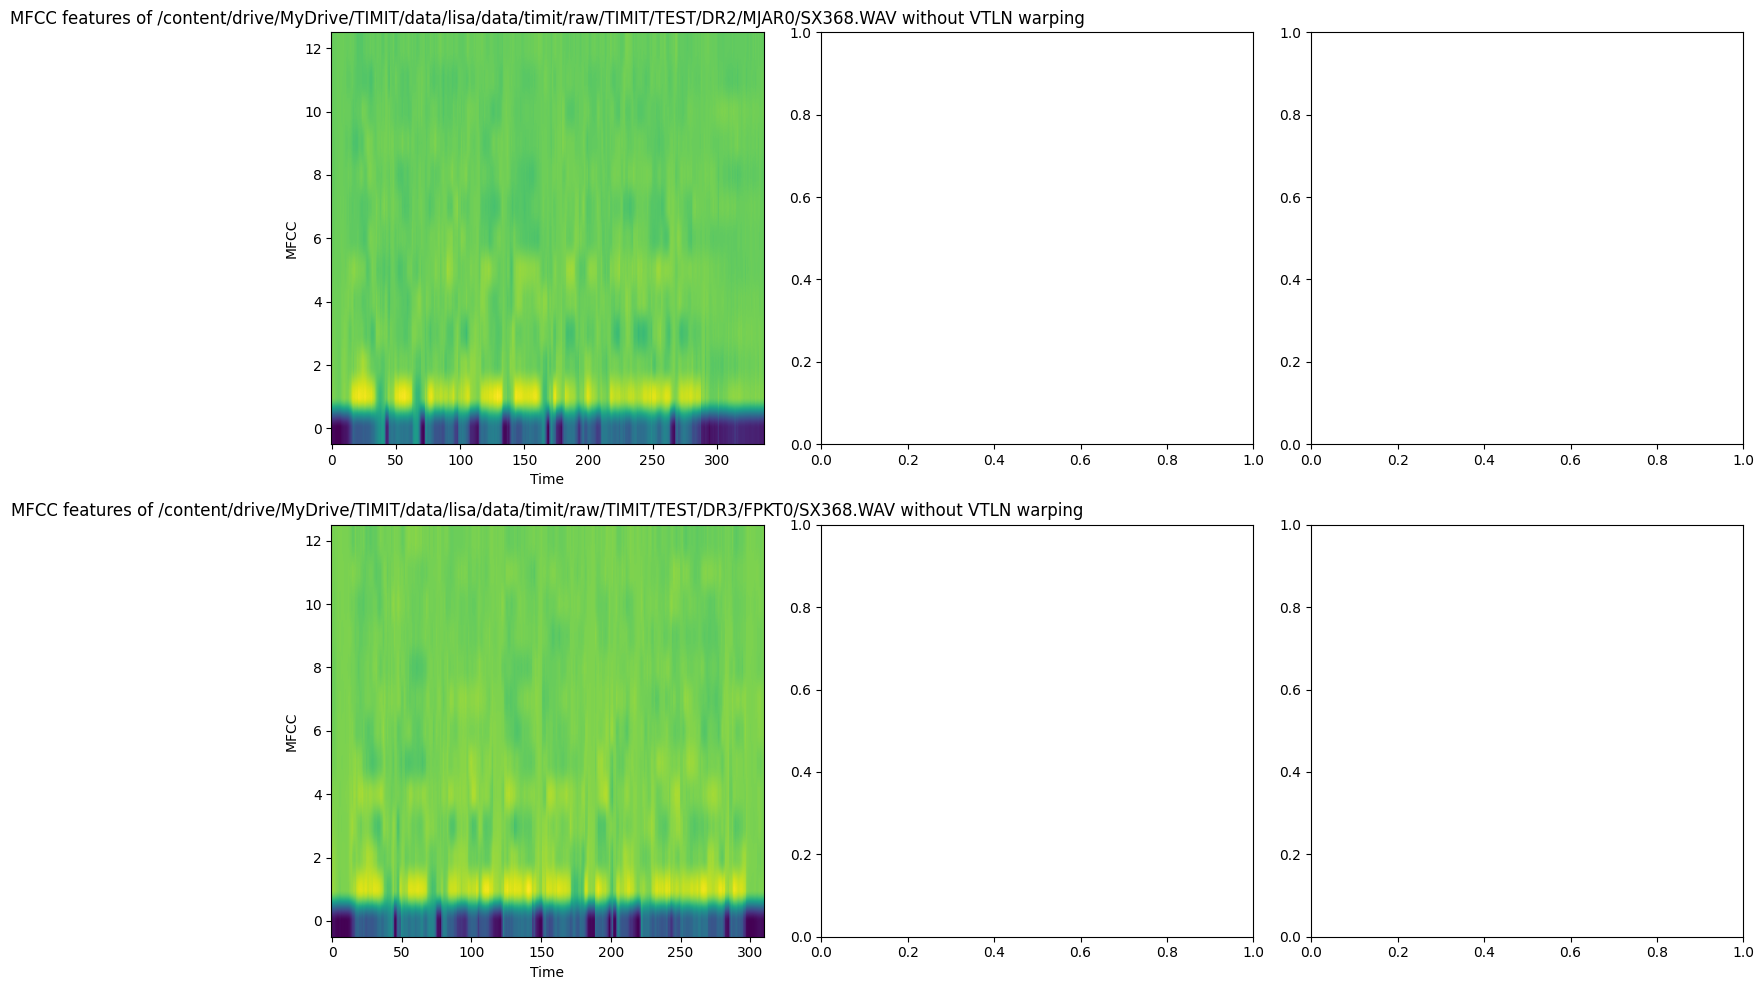

In [3]:
# Import libraries
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Define spectral feature extraction function
def extract_features(wav_file, feature_type='mfcc', n_mfcc=13, n_fft_ms=25, hop_length_ms=10, win_length_ms=25, n_components=32, max_iter=100):

  # Load audio file
  y, sr = librosa.load(wav_file, sr=None)

  # Convert window size arguments from milliseconds to samples
  n_fft = int(n_fft_ms * sr / 1000)
  hop_length = int(hop_length_ms * sr / 1000)
  win_length = int(win_length_ms * sr / 1000)

  # Compute power spectrum
  S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length))**2

  # Apply feature type
  if feature_type == 'mfcc':
    # Compute MFCCs
    F = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
  elif feature_type == 'plp':
    # Compute PLPs
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length))**2
    # Compute the root mean square energy
    F = librosa.feature.rms(S=S, frame_length=win_length, hop_length=hop_length)**2
    # Multiply by the MFCCs
    F = F * librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    # F = librosa.feature.rms(S=librosa.power_to_db(S), n_mfcc=n_mfcc)**2 * librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
  elif feature_type == 'mfcc-tmp':
    # Compute MFCC-TMPs
    F = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    F = np.concatenate((F, librosa.feature.tempogram(y=y, onset_envelope=F[0], sr=sr, hop_length=hop_length)), axis=0)
  else:
    # Invalid feature type
    raise ValueError('Invalid feature type: {}'.format(feature_type))

  # Return feature matrix
  return F

# Define a list of audio files to test
test_files = [
    timit_dataset_path + '/data/lisa/data/timit/raw/TIMIT/TEST/DR2/MJAR0/SX368.WAV',
    timit_dataset_path + '/data/lisa/data/timit/raw/TIMIT/TEST/DR3/FPKT0/SX368.WAV'
]

# Define a list of feature types to test
feature_types = [
    'mfcc',
    # 'plp',
    # 'mfcc-tmp'
]

# Create a figure with 6 subplots (2 rows and 3 columns)
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Loop over the test files and feature types
for i, wav_file in enumerate(test_files):
  for j, feature_type in enumerate(feature_types):
    # Extract features without VTLN warping
    F = extract_features(wav_file, feature_type=feature_type, n_fft_ms=25, hop_length_ms=10, win_length_ms=25)
    # Plot the features without VTLN warping on the corresponding subplot
    ax[i, j].imshow(F, aspect='auto', origin='lower', cmap='viridis')
    ax[i, j].set_title(f'{feature_type.upper()} features of {wav_file} without VTLN warping')
    ax[i, j].set_xlabel('Time')
    ax[i, j].set_ylabel(feature_type.upper())

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# VTLN Warping Factor Estimation

We will use the sklearn library to estimate the VTLN warping factors for each utterance using an unsupervised Gaussian mixture model (GMM) framework6. The idea is to fit a GMM to the feature vectors of each utterance and compute the posteriorgrams, which are the posterior probabilities of each feature vector belonging to each Gaussian component. Then, we compute the mean posteriorgram, which is the average of the posteriorgrams over time. We assume that the mean posteriorgram has a peak that corresponds to the dominant frequency of the speaker’s vocal tract. We use the peak index to compute the warping factor, which is the ratio of the peak index to the number of features. We use the following function to estimate the VTLN warping factor for a given audio file.



In [ ]:
# Define VTLN warping factor estimation function
def estimate_vtln_factor(wav_file, feature_type='mfcc', n_mfcc=13, n_fft=512, hop_length=160, win_length=400, n_components=32, max_iter=100):
  # Extract features
  F = extract_features(wav_file, feature_type, n_mfcc, n_fft, hop_length, win_length)
  # Initialize GMM
  gmm = sklearn.mixture.GaussianMixture(n_components=n_components, max_iter=max_iter)
  # Fit GMM to features
  gmm.fit(F.T)
  # Compute posteriorgrams
  P = gmm.predict_proba(F.T).T
  # Compute mean posteriorgram
  P_mean = np.mean(P, axis=1)
  # Find the peak index
  peak_idx = np.argmax(P_mean)
  # Compute the warping factor
  alpha = (peak_idx + 1) / (n_mfcc + 1)
  # Return the warping factor
  return alpha


# VTLN Warping

We will use the librosa library to apply the VTLN warping to each utterance using the estimated warping factor7. The idea is to resample the audio signal with the warping factor, which effectively stretches or shrinks the frequency axis of the signal. Then, we extract the features from the warped audio signal using the same function as before. We use the following function to apply the VTLN warping to a given audio file:

In [ ]:
# Define VTLN warping function
def apply_vtln_warping(wav_file, alpha, feature_type='mfcc', n_mfcc=13, n_fft=512, hop_length=160, win_length=400):
  # Load audio file
  y, sr = librosa.load(wav_file, sr=None)
  # Resample the audio with the warping factor
  y_warp = librosa.resample(y, sr, sr * alpha)
  # Extract features from the warped audio
  F_warp = extract_features(y_warp, feature_type, n_mfcc, n_fft, hop_length, win_length)
  # Return the warped features
  return F_warp

# Example Usage

We will use the following code to demonstrate the usage of the above functions. We will estimate the VTLN warping factor for an example utterance and apply the VTLN warping to it4. We will print the warping factor and the feature shape, and plot the original and warped features.



In [ ]:
# Example usage
# Estimate the VTLN warping factor for an utterance[^7^][7]
alpha = estimate_vtln_factor('example.wav', feature_type='mfcc')
# Apply the VTLN warping to the utterance
F_warp = apply_vtln_warping('example.wav', alpha, feature_type='mfcc')
# Print the warping factor and the feature shape
print('Warping factor: {:.2f}'.format(alpha))
print('Feature shape: {}'.format(F_warp.shape))
# Plot the original and warped features
import matplotlib.pyplot as plt
F = extract_features('example.wav', feature_type='mfcc')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(F, aspect='auto', origin='lower')
plt.title('Original features')
plt.xlabel('Time')
plt.ylabel('MFCC')
plt.subplot(1, 2, 2)
plt.imshow(F_warp, aspect='auto', origin='lower')
plt.title('Warped features')
plt.xlabel('Time')
plt.ylabel('MFCC')
plt.show()
